# Ablation num neighbors

In [52]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
import corc.utils
import corc.graph_metrics.neb
import corc.graph_metrics.tmm_gmm_neb
import sklearn.metrics
import pickle
import os
import corc.our_datasets
import numpy as np
from scipy.spatial import distance
import itertools
import tqdm

cache_folder = "../cache"

In [54]:
datasets = corc.our_datasets.CORE_HD_DATASETS
datasets

['densired8',
 'densired16',
 'densired32',
 'densired64',
 'densired_soft_8',
 'densired_soft_16',
 'densired_soft_32',
 'densired_soft_64',
 'mnist8',
 'mnist16',
 'mnist32',
 'mnist64']

In [55]:
import jax.numpy as jnp

def subselect_adjacency_matrix(adjacency_matrix, centers, knn):
    """
    Subselect the adjacency matrix to include only the knn nearest neighbors of each center.

    Parameters:
    adjacency_matrix (np.ndarray): The original adjacency matrix.
    centers (np.ndarray): The list of centers.
    knn (int): The number of nearest neighbors to include.

    Returns:
    np.ndarray: The subselected adjacency matrix.
    """
    num_centers = len(centers)

    distances = jnp.linalg.norm(centers[:, None, :] - centers[None, :, :], axis=-1)
    indices = jnp.argsort(distances, axis=-1)[:, 1 : (knn + 1)]
    pair_i, pair_j = jnp.meshgrid(
        jnp.arange(num_centers), jnp.arange(indices.shape[1]), indexing="ij"
    )
    pairs = (pair_i.flatten(), indices.flatten())
    mask = np.zeros((num_centers, num_centers), dtype=bool)
    mask[pairs] = True
    mask[pairs[1], pairs[0]] = True

    # Create the subselected adjacency matrix
    subselected_adjacency_matrix = np.where(mask, adjacency_matrix, 0)

    return subselected_adjacency_matrix

in order to create the pickle file, please run ablation_k_neighbors_tmm_fitting.py on a GPU node.

In [ ]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

# Load the pickled all_tmms dictionary
filename = os.path.join(cache_folder, "ablations", "tmms_fitted_all_pairs.pickle")
with open(filename, "rb") as f:
    all_tmms = pickle.load(f)

# Create lists to store the ARI values for each dataset
ari_values = dict()
dataset_names = list(all_tmms.keys())
# dataset_names = ["densired_soft_8"]

# Loop through each dataset
for dataset in tqdm.tqdm(dataset_names):
    tmm = all_tmms[dataset]
    X,y,_ = corc.utils.load_dataset(dataset, cache_path=cache_folder)
    ari_values_dataset = []

    # # test ARI
    # y_pred = tmm.predict_with_target(X, len(np.unique(y)))
    # print(f"starting ARI {sklearn.metrics.adjusted_rand_score(y,y_pred)}")
    
    # Loop through each k value
    for k in range(len(tmm.mixture_model.weights)):
        raw_adj = subselect_adjacency_matrix(tmm.raw_adjacency_, tmm.mixture_model.centers, k+1)
        tmm.adjacency_ = corc.graph_metrics.tmm_gmm_neb.compute_mst_distances(raw_adj)
        y_pred = tmm.predict_with_target(X, len(np.unique(y)))
        ari = sklearn.metrics.adjusted_rand_score(y, y_pred)
        ari_values_dataset.append(ari)
        # print(f"{dataset} k={k}: ARI {ari}")

    # tmm.adjacency_ = corc.graph_metrics.tmm_gmm_neb.compute_mst_distances(tmm.raw_adjacency_)
    # y_pred = tmm.predict_with_target(X, len(np.unique(y)))
    # print(f"starting ARI {sklearn.metrics.adjusted_rand_score(y,y_pred)}")

    # Append the ARI values
    ari_values[dataset] = ari_values_dataset


starting ARI 0.9139723855398172
6 clusters is not achievable.
Working with 1 clusters instead.
densired8 k=0: ARI 0.0
densired8 k=1: ARI 0.9139723855398172
densired8 k=2: ARI 0.9139723855398172
densired8 k=3: ARI 0.9139723855398172
densired8 k=4: ARI 0.9139723855398172
densired8 k=5: ARI 0.9139723855398172
densired8 k=6: ARI 0.9139723855398172
densired8 k=7: ARI 0.9139723855398172
densired8 k=8: ARI 0.9139723855398172
densired8 k=9: ARI 0.9139723855398172
densired8 k=10: ARI 0.9139723855398172
densired8 k=11: ARI 0.9139723855398172
densired8 k=12: ARI 0.9139723855398172
densired8 k=13: ARI 0.9139723855398172
densired8 k=14: ARI 0.9139723855398172
densired8 k=15: ARI 0.9139723855398172
densired8 k=16: ARI 0.9139723855398172
densired8 k=17: ARI 0.9139723855398172
densired8 k=18: ARI 0.9139723855398172
densired8 k=19: ARI 0.9139723855398172
densired8 k=20: ARI 0.9139723855398172
densired8 k=21: ARI 0.9139723855398172
densired8 k=22: ARI 0.9139723855398172
densired8 k=23: ARI 0.91397238553

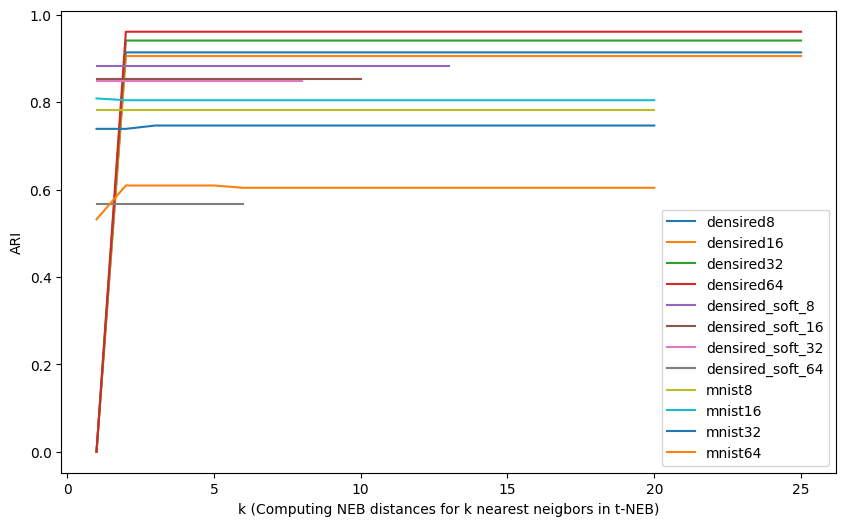

In [66]:

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the absolute ARI values
for i, dataset in enumerate(dataset_names):
    plt.plot(np.array(range(len(ari_values[dataset])))+1,ari_values[dataset], label=dataset)

plt.xlabel('k (Computing NEB distances for k nearest neigbors in t-NEB)')
plt.ylabel('ARI')
# plt.title('Absolute ARI Values')
plt.legend()
plt.savefig("../figures/ablation_k_neighbors.pdf")
plt.show()

In [5]:
def get_tNEB(dataset_name, cache_path):
    filename = os.path.join(cache_path, f"{dataset_name}_TMM-NEB.pickle")
    if os.path.exists(filename):
        with open(filename, "rb") as f:
            tmm = pickle.load(f)[0]
    else:
        X, y, tsne = corc.utils.load_dataset(dataset_name)
        tmm = corc.graph_metrics.neb.NEB(
            data=X, labels=y, n_components=15, optimization_iterations=1
        )
        tmm.fit(X)  # the fitting essentially initializes the mixture model
    return tmm

all_tmms = dict()
for dataset in datasets:
    tmm = get_tNEB(dataset, "../cache")
    tmm.fit(X, knn=None)
    all_tmms[dataset] = tmm

In [7]:
tmm = get_tNEB(dataset_name, "../cache")

In [9]:
tmm.fit(X, knn=None)

[[373  49]
 [331  38]
 [547  41]
 [449  55]
 [440  52]
 [422  49]
 [225  67]
 [472  61]
 [306  68]
 [304  51]
 [313  48]
 [435  48]
 [262  55]
 [490  31]
 [345  40]
 [281  51]
 [352  49]
 [503  56]
 [284  98]
 [813  40]
 [390  40]
 [446  34]
 [434  46]
 [348  39]
 [435  40]]
After filtering 25 components, we are left with 25 components


t-NEB: 100%|██████████| 1/1 [00:28<00:00, 28.03s/it]


In [6]:
dataset_name = "densired32"
# dataset_name = "mnist16"
X,y,tsne = corc.utils.load_dataset(dataset_name)

In [10]:
import pickle

with open(f"../cache/ablations/k_neighbors_{dataset_name}.pkl", "wb") as f:
    pickle.dump(tmm, f)

In [11]:
with open(f"../cache/ablations/k_neighbors_{dataset_name}.pkl", "rb") as f:
    tmm = pickle.load(f)

In [122]:
raw_adj = subselect_adjacency_matrix(tmm.raw_adjacency_, tmm.mixture_model.centers, 1)
raw_adj

array([[  0.        ,   0.        ,   3.20275187,   0.        ,
          0.        ,  -0.2779457 ,   0.        ,   0.        ,
          0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,  26.23476791,  30.62001801,
          0.        ],
       [  3.20275187,   0.        ,   0.        ,  31.17840385,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ],
       [  0.        ,   0.        ,  31.17840385,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
         34.49775696],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        , -17.19381905,
          0.        ],
       [ -0.2779457 ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ],
       [  0.        ,  26.23476791,   0.        ,   0.        ,
          0.        ,   0.    

In [123]:
np.count_nonzero(raw_adj)

14

In [ ]:
for k in range(len(tmm.mixture_model.weights)):
    raw_adj = subselect_adjacency_matrix(tmm.raw_adjacency_+1, tmm.mixture_model.centers, k+1)
    tmm.adjacency_ = corc.graph_metrics.tmm_gmm_neb.compute_mst_distances(raw_adj)
    y_pred = tmm.predict_with_target(X, len(np.unique(y)))
    ari = sklearn.metrics.adjusted_rand_score(y, y_pred)
    print(f"k = {k+1}, ari = {ari}")

6 clusters is not achievable.
Working with 1 clusters instead.
k = 1, ari = 0.0
k = 2, ari = 0.7634215908240864
k = 3, ari = 0.9003961036790805
k = 4, ari = 0.9003961036790805
k = 5, ari = 0.9003961036790805
k = 6, ari = 0.9003961036790805
k = 7, ari = 0.9003961036790805
k = 8, ari = 0.9003961036790805
k = 9, ari = 0.9003961036790805
k = 10, ari = 0.9003961036790805
k = 11, ari = 0.9003961036790805
k = 12, ari = 0.9003961036790805
k = 13, ari = 0.9003961036790805
k = 14, ari = 0.9003961036790805
k = 15, ari = 0.9003961036790805
k = 16, ari = 0.9003961036790805
k = 17, ari = 0.9003961036790805
k = 18, ari = 0.9003961036790805
k = 19, ari = 0.9003961036790805
k = 20, ari = 0.9003961036790805
k = 21, ari = 0.9003961036790805
k = 22, ari = 0.9003961036790805
k = 23, ari = 0.9003961036790805
k = 24, ari = 0.9003961036790805
k = 25, ari = 0.9003961036790805
k = 26, ari = 0.9003961036790805
k = 27, ari = 0.9003961036790805
k = 28, ari = 0.9003961036790805
k = 29, ari = 0.9003961036790805
k = 

In [124]:
corc.graph_metrics.tmm_gmm_neb.compute_mst_distances(adj)
corc.graph_metrics.tmm_gmm_neb.compute_mst_distances(raw_adj)

array([[  0.        ,          inf,   3.20275187,   3.20275187,
                 inf,  -0.2779457 ,          inf,          inf,
          3.20275187],
       [         inf,   0.        ,          inf,          inf,
        -17.19381905,          inf,  26.23476791,  30.62001801,
                 inf],
       [  3.20275187,          inf,   0.        ,  31.17840385,
                 inf,  -0.2779457 ,          inf,          inf,
         31.17840385],
       [  3.20275187,          inf,  31.17840385,   0.        ,
                 inf,  -0.2779457 ,          inf,          inf,
         34.49775696],
       [         inf, -17.19381905,          inf,          inf,
          0.        ,          inf, -17.19381905, -17.19381905,
                 inf],
       [ -0.2779457 ,          inf,  -0.2779457 ,  -0.2779457 ,
                 inf,   0.        ,          inf,          inf,
         -0.2779457 ],
       [         inf,  26.23476791,          inf,          inf,
        -17.19381905,         

In [126]:
y_pred = tmm.predict_with_target(X, 6)
sklearn.metrics.adjusted_rand_score(y, y_pred)

0.8640218314265484

In [83]:
X_densired,y_densired,tsne_densired = corc.utils.load_dataset("densired_soft_16")
tmm = corc.graph_metrics.neb.NEB(
    data=X_densired,
    labels=y_densired,
    n_components=30,
    optimization_iterations=1,
    n_neighbors=100,
    tmm_regularization=1e-4,
)
tmm.fit(X_densired, knn=1)

[[      8  981898]
 [   1211       7]
 [   1134       4]
 [   1217       8]
 [   1380       7]
 [   1158       6]
 [      1       1]
 [    536       4]
 [      1       1]
 [      2     189]
 [      1       1]
 [    773       8]
 [      1       1]
 [      1       1]
 [      1       1]
 [      2     187]
 [    773       6]
 [      1       1]
 [      1       1]
 [      1       1]
 [      1       1]
 [    895      10]
 [      5 3224997]
 [      1       1]
 [      8 1071925]
 [      1       1]
 [      1       1]
 [      1       1]
 [    882       7]
 [      2     796]]
After filtering 30 components, we are left with 10 components
[[1215    7]
 [1139    4]
 [1221    8]
 [1384    7]
 [1163    6]
 [ 537    4]
 [ 777    8]
 [ 778    6]
 [ 899   10]
 [ 887    7]]


tmm: 100%|██████████| 10/10 [00:00<00:00, 110.46it/s]

In [85]:
elongations = [[      8,  981898],
 [   1211,       7],
 [   1134,       4],
 [   1217,       8],
 [   1380,       7],
 [   1158,       6],
 [      1,       1],
 [    536,       4],
 [      1,       1],
 [      2,     189],
 [      1,       1],
 [    773,       8],
 [      1,       1],
 [      1,       1],
 [      1,       1],
 [      2,     187],
 [    773,       6],
 [      1,       1],
 [      1,       1],
 [      1,       1],
 [      1,       1],
 [    895,      10],
 [      5, 3224997],
 [      1,       1],
 [      8, 1071925]]

In [86]:
import pandas as pd

In [102]:
df = pd.DataFrame(elongations)
df.columns = ['counts', 'elongations']
# df.index.name = 'component id'
# df.style.hide_index()
df

,counts,elongations
0,8,981898
1,1211,7
2,1134,4
3,1217,8
4,1380,7
5,1158,6
6,1,1
7,536,4
8,1,1
9,2,189


starting ARI 0.8833875240681565
densired_soft_8 k=0: ARI 0.8833875240681565
densired_soft_8 k=1: ARI 0.8833875240681565
densired_soft_8 k=2: ARI 0.8833875240681565
densired_soft_8 k=3: ARI 0.8833875240681565
densired_soft_8 k=4: ARI 0.8833875240681565
densired_soft_8 k=5: ARI 0.8833875240681565
densired_soft_8 k=6: ARI 0.8833875240681565
densired_soft_8 k=7: ARI 0.8833875240681565
densired_soft_8 k=8: ARI 0.8833875240681565
densired_soft_8 k=9: ARI 0.8833875240681565
densired_soft_8 k=10: ARI 0.8833875240681565
densired_soft_8 k=11: ARI 0.8833875240681565
densired_soft_8 k=12: ARI 0.8833875240681565
starting ARI 0.8833875240681565


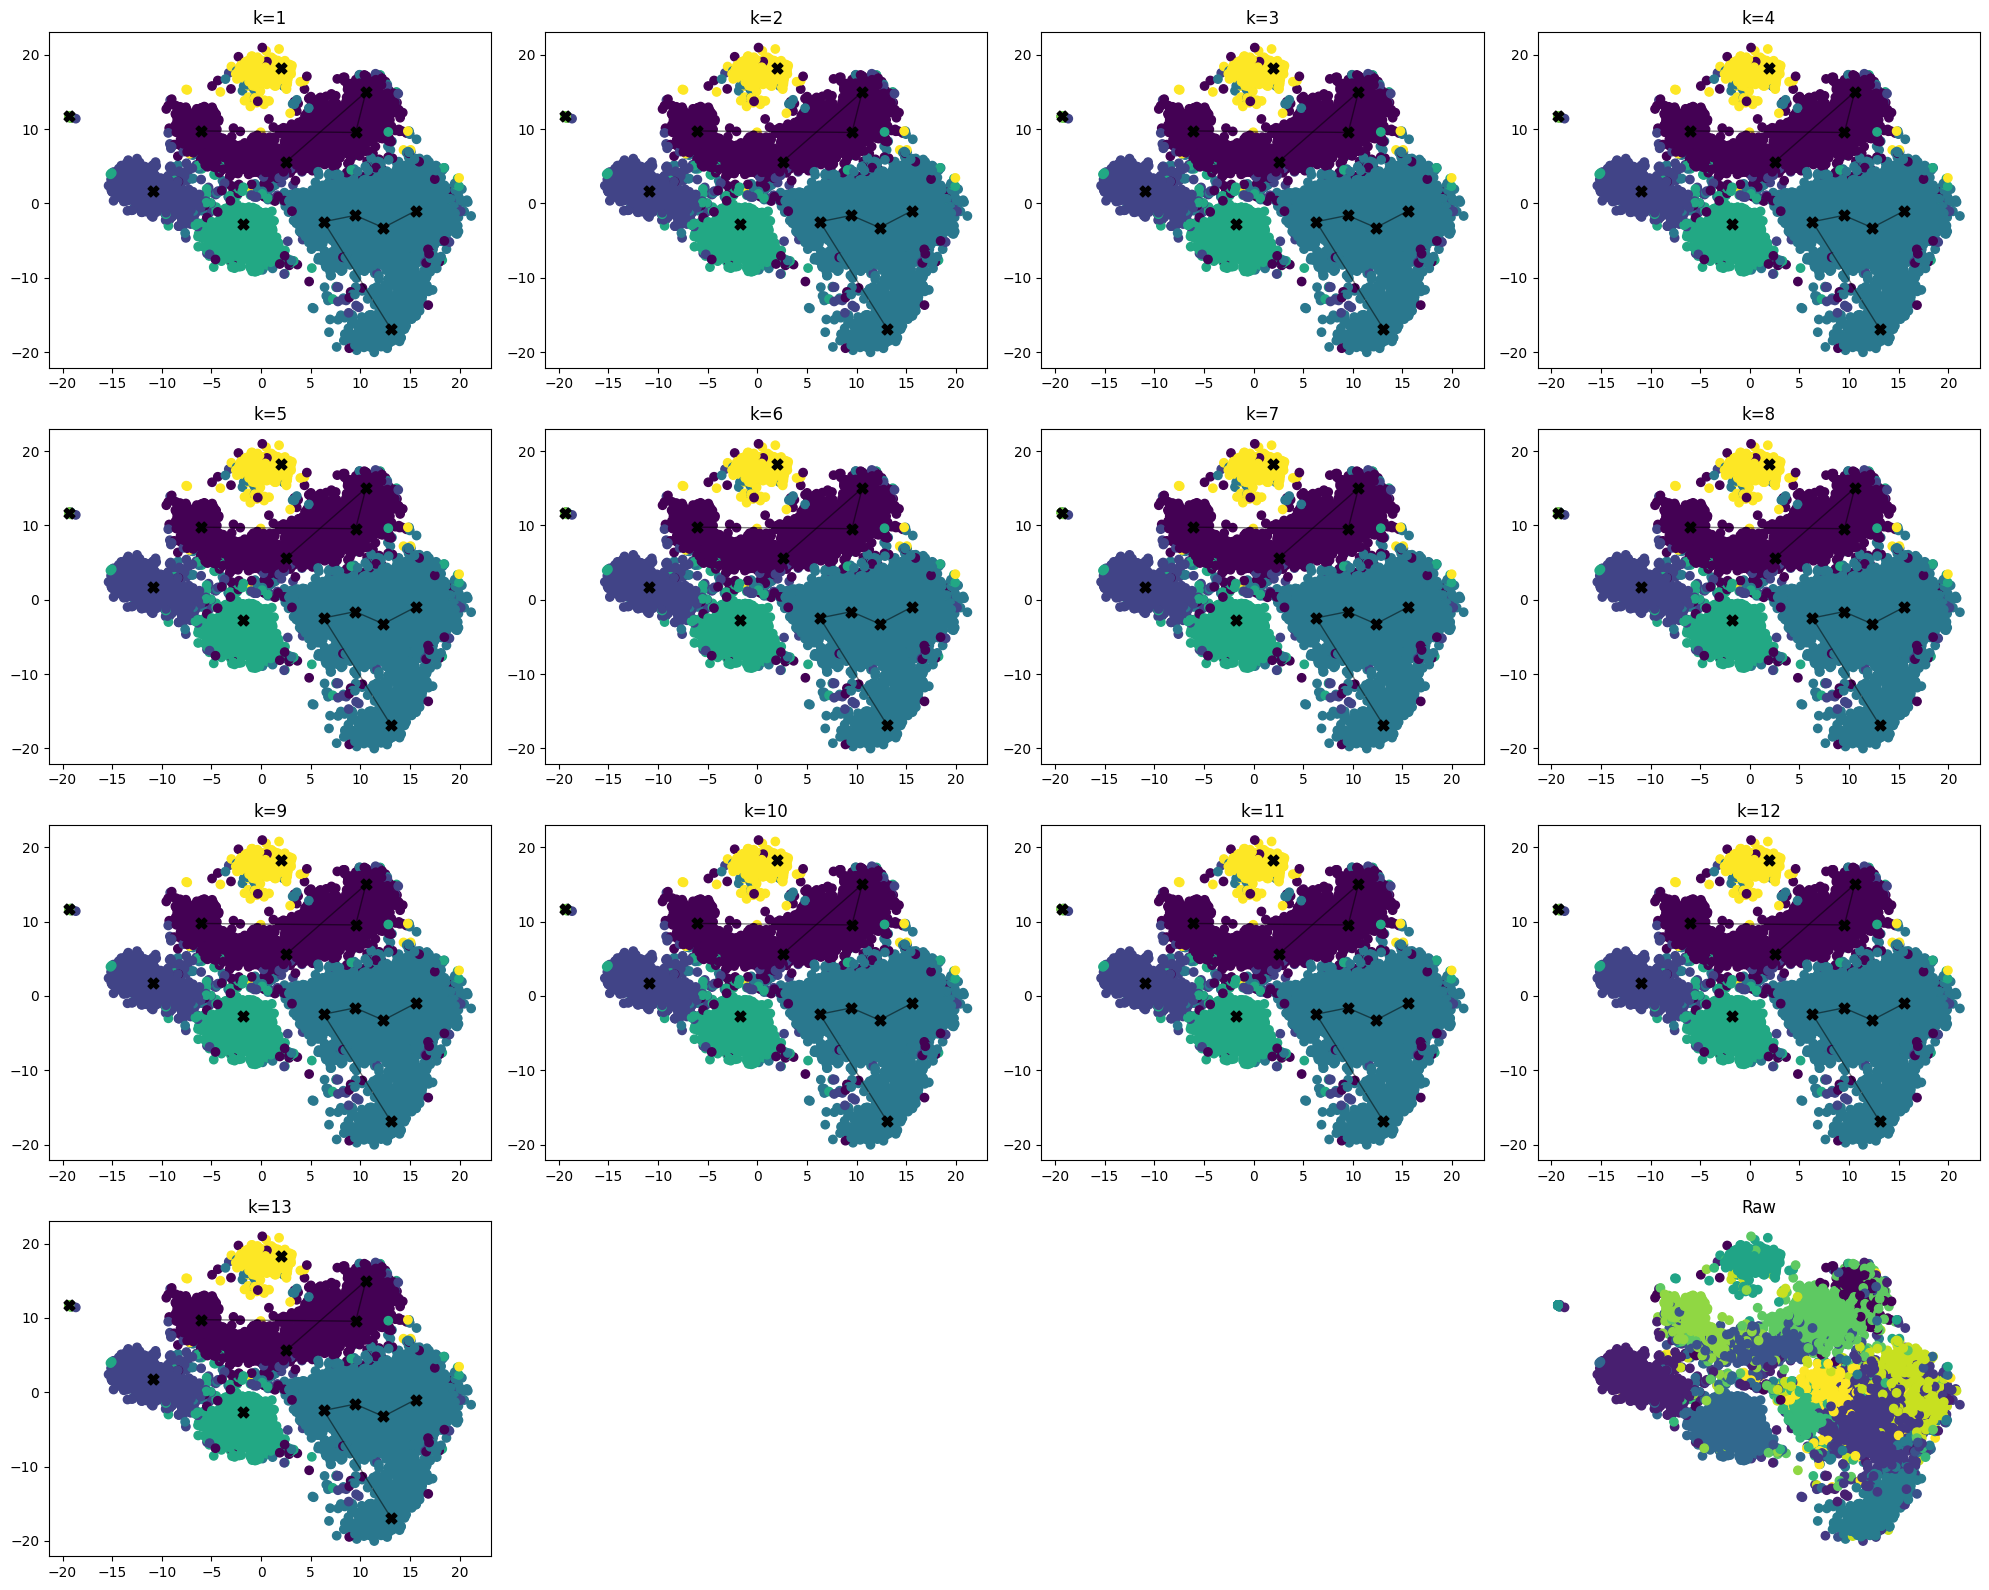

In [58]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

# Load the pickled all_tmms dictionary
filename = os.path.join(cache_folder, "ablations", "tmms_fitted_all_pairs.pickle")
with open(filename, "rb") as f:
    all_tmms = pickle.load(f)

# Create lists to store the ARI values for each dataset
ari_values = dict()
dataset_names = ["densired_soft_8"]

# Loop through each dataset
for dataset in dataset_names:
    tmm = all_tmms[dataset]
    X,y,tsne = corc.utils.load_dataset(dataset, cache_path=cache_folder)
    ari_values_dataset = []

    # test ARI
    y_pred = tmm.predict_with_target(X, len(np.unique(y)))
    print(f"starting ARI {sklearn.metrics.adjusted_rand_score(y,y_pred)}")
    
    # Loop through each k value
    for k in range(len(tmm.mixture_model.weights)):
        raw_adj = subselect_adjacency_matrix(tmm.raw_adjacency_, tmm.mixture_model.centers, k+1)
        tmm.adjacency_ = corc.graph_metrics.tmm_gmm_neb.compute_mst_distances(raw_adj)
        y_pred = tmm.predict_with_target(X, len(np.unique(y)))
        ari = sklearn.metrics.adjusted_rand_score(y, y_pred)
        ari_values_dataset.append(ari)
        print(f"{dataset} k={k}: ARI {ari}")

    tmm.adjacency_ = corc.graph_metrics.tmm_gmm_neb.compute_mst_distances(tmm.raw_adjacency_)
    y_pred = tmm.predict_with_target(X, len(np.unique(y)))
    print(f"starting ARI {sklearn.metrics.adjusted_rand_score(y,y_pred)}")

    # Append the ARI values
    ari_values[dataset] = ari_values_dataset

# Create the plots
n_rows = int(np.ceil(len(tmm.mixture_model.weights) / 4))
fig, axs = plt.subplots(n_rows, 4, figsize=(20, n_rows * 4))

# Plot the scatter plots for each k
for i, k in enumerate(range(len(tmm.mixture_model.weights))):
    row = i // 4
    col = i % 4
    raw_adj = subselect_adjacency_matrix(tmm.raw_adjacency_, tmm.mixture_model.centers, k+1)
    tmm.adjacency_ = corc.graph_metrics.tmm_gmm_neb.compute_mst_distances(raw_adj)
    y_pred = tmm.predict_with_target(X, len(np.unique(y)))
    axs[row, col].scatter(tsne[:, 0], tsne[:, 1], c=y_pred, cmap='viridis')
    axs[row, col].set_title('k=' + str(k+1))
    tmm.data = X
    tmm.plot_graph(X2D=tsne, target_num_clusters=6, ax=axs[row,col])

# Create a "raw" plot that evaluates tmm.mixture_model.predict()
tmm.adjacency_ = corc.graph_metrics.tmm_gmm_neb.compute_mst_distances(tmm.raw_adjacency_)
y_pred = tmm.mixture_model.predict(X)
axs[-1, -1].scatter(tsne[:, 0], tsne[:, 1], c=y_pred, cmap='viridis')
axs[-1, -1].set_title('Raw')

# Hide unused subplots
for i in range(len(tmm.mixture_model.weights), n_rows * 4):
    row = i // 4
    col = i % 4
    axs[row, col].axis('off')

# Show the plots
plt.tight_layout()
plt.show()